In [1]:
#https://github.com/keras-team/keras/issues/4161#issuecomment-366031228
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
                                    # (nothing gets printed in Jupyter, only if you run it standalone)
sess = tf.Session(config=config)
set_session(sess)  # set this TensorFlow session as the default session for Keras



Using TensorFlow backend.


In [2]:
from IPython import get_ipython



In [3]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import glob
from skimage.color import rgb2lab
from skimage.transform import resize
from collections import namedtuple



In [4]:
def current_name(folder, postfix):
    import time
    timestr = time.strftime("%y%m%d_%H%M%S")
    file_name = os.path.join('.',folder,timestr + postfix)
    print(file_name)
    return file_name



In [5]:
import numpy as np
import pandas as pd



In [6]:
def current_name(folder, postfix):
    import time
    timestr = time.strftime("%y%m%d_%H%M%S")
    file_name = os.path.join('.',folder,timestr + postfix)
    print(file_name)
    return file_name



In [7]:
import numpy as np
import pandas as pd



In [8]:
np.random.seed(2019)
get_ipython().run_line_magic('matplotlib', 'inline')



In [9]:
import os
os.listdir("./")



['.ipynb',
 '.ipynb_checkpoints',
 '190729_resnet50_transfer.ipynb',
 '190817_preprocessing-Copy1.ipynb',
 '190817_preprocessing.ipynb',
 '190817_VGG16.ipynb',
 '190819_inception_resnet2-v1.ipynb',
 '190821_Densenet.ipynb',
 '190821_densenet_v2.ipynb',
 '190821_resnet.ipynb',
 'Atos2019-ver1-Copy1.ipynb',
 'Atos2019-ver1.ipynb',
 'EDA_starter_resnet50-Copy1.ipynb',
 'EDA_starter_resnet50.ipynb',
 'gpu_configProto.ipynb',
 'input',
 'Intro APTOS Diabetic Retinopathy_EDA_Starter.ipynb',
 'Keras baseline.ipynb',
 'MODEL',
 'out.png',
 'resnet50_baseline-Copy1.ipynb',
 'resnet50_baseline.ipynb',
 'save',
 'simpleCNN',
 'submission',
 'submission.csv',
 'test.png',
 'Untitled.ipynb',
 'Untitled1.ipynb',
 'Untitled2.ipynb',
 'WORKING']

In [10]:
os.listdir("./input/models")



['DenseNet-BC-121-32-no-top.h5',
 'DenseNet-BC-121-32.h5',
 'DenseNet-BC-161-48-no-top.h5',
 'DenseNet-BC-161-48.h5',
 'DenseNet-BC-169-32-no-top.h5',
 'DenseNet-BC-169-32.h5',
 'inception_resnet_v2_weights_tf_dim_ordering_tf_kernels.h5',
 'inception_resnet_v2_weights_tf_dim_ordering_tf_kernels_notop.h5',
 'resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
 'vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5']

In [11]:
from keras.models import Model
from keras import optimizers, applications
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input



In [12]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())



[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13631294610727171070
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6682591232
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8608331466507738337
physical_device_desc: "device: 0, name: GeForce GTX 1070 Ti, pci bus id: 0000:07:00.0, compute capability: 6.1"
]


In [13]:
train_dir = "./input/train_images"
df_train = pd.read_csv("./input/train.csv")
df_test = pd.read_csv("./input/test.csv")
df_train['path'] = df_train['id_code'].map(lambda x: os.path.join(train_dir, '{}.png'.format(x)))


 #### EDA (Explanatory Data Analysis)

In [14]:
df = df_train
df.shape



(3662, 3)

Text(0.5, 1.0, 'Samples Per Class')

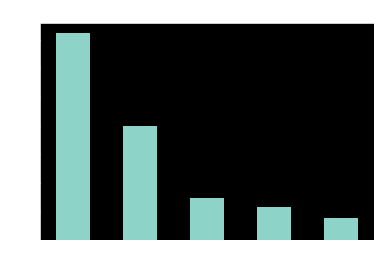

In [15]:
df['diagnosis'].value_counts().plot(kind='bar')
plt.title('Samples Per Class')



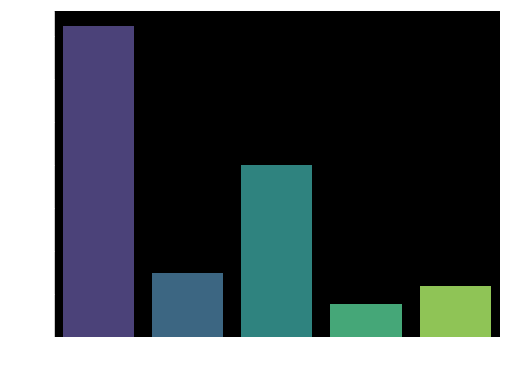

In [16]:
import seaborn as sns
f, ax = plt.subplots(figsize=(8, 6))
ax = sns.countplot(x='diagnosis', data=df_train, palette='viridis')
sns.despine()
plt.show()



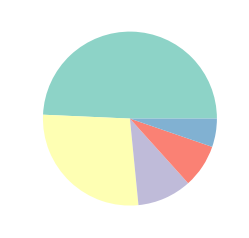

In [17]:
df['diagnosis'].value_counts().plot(kind='pie')



In [18]:
NUM_CLASSES = df_train['diagnosis'].nunique()
print(NUM_CLASSES)



5


In [19]:
df_train.head()



id_code  diagnosis                                   path
0  000c1434d8d7          2  ./input/train_images\000c1434d8d7.png
1  001639a390f0          4  ./input/train_images\001639a390f0.png
2  0024cdab0c1e          1  ./input/train_images\0024cdab0c1e.png
3  002c21358ce6          0  ./input/train_images\002c21358ce6.png
4  005b95c28852          0  ./input/train_images\005b95c28852.png

In [20]:
df.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3662 entries, 0 to 3661
Data columns (total 3 columns):
id_code      3662 non-null object
diagnosis    3662 non-null int64
path         3662 non-null object
dtypes: int64(1), object(2)
memory usage: 85.9+ KB


In [21]:
df_train['diagnosis']=df_train['diagnosis'].astype('str')



In [22]:
df_train['id_file'] = df_train['id_code'] + '.png'



In [23]:
os.listdir(train_dir)[0:10]



['000c1434d8d7.png',
 '001639a390f0.png',
 '0024cdab0c1e.png',
 '002c21358ce6.png',
 '005b95c28852.png',
 '0083ee8054ee.png',
 '0097f532ac9f.png',
 '00a8624548a9.png',
 '00b74780d31d.png',
 '00cb6555d108.png']

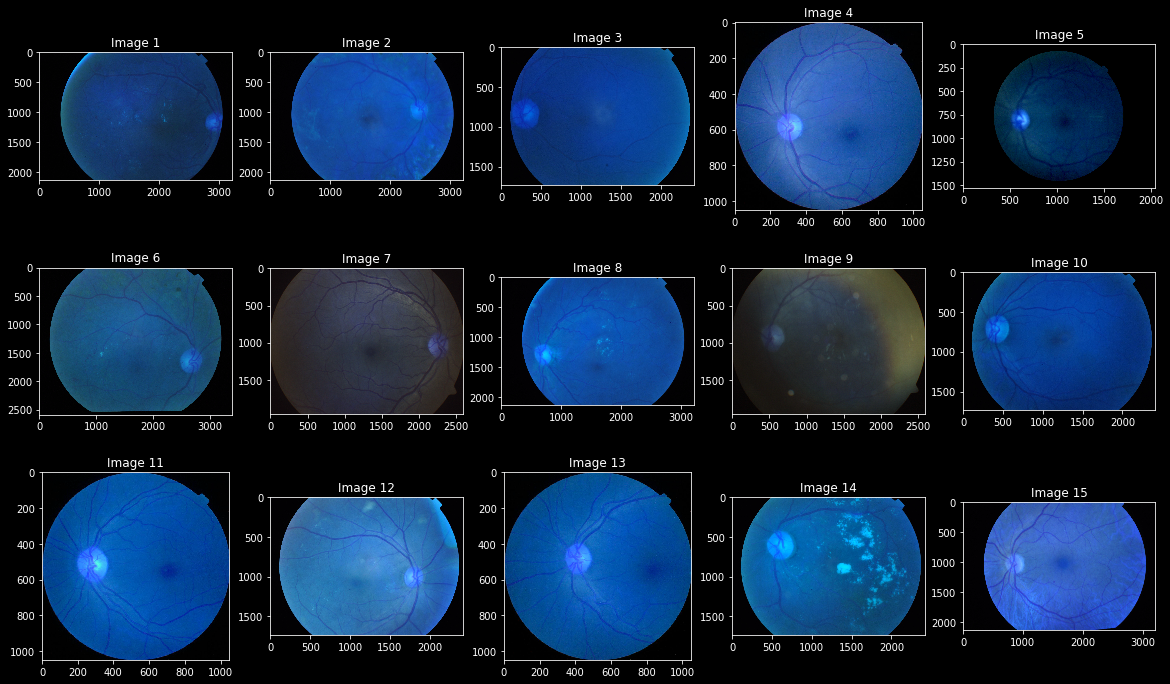

In [24]:
#sns.set_style('white')
plt.style.use('dark_background')
#plt.style.use('ggplot')
import cv2
count = 1
plt.figure(figsize=[20, 20])
for img_name in df_train['path'][0:15]:
    img = cv2.imread(img_name)
    plt.subplot(5,5,count)
    plt.imshow(img)
    plt.title('Image %s' % count)
    count += 1
    



In [25]:
# from PIL import Image

# img = Image.open(df_train['path'][1])
# width, height = img.size
# print(width, height)
# img.show()
# plt.imshow(np.asarray(img))



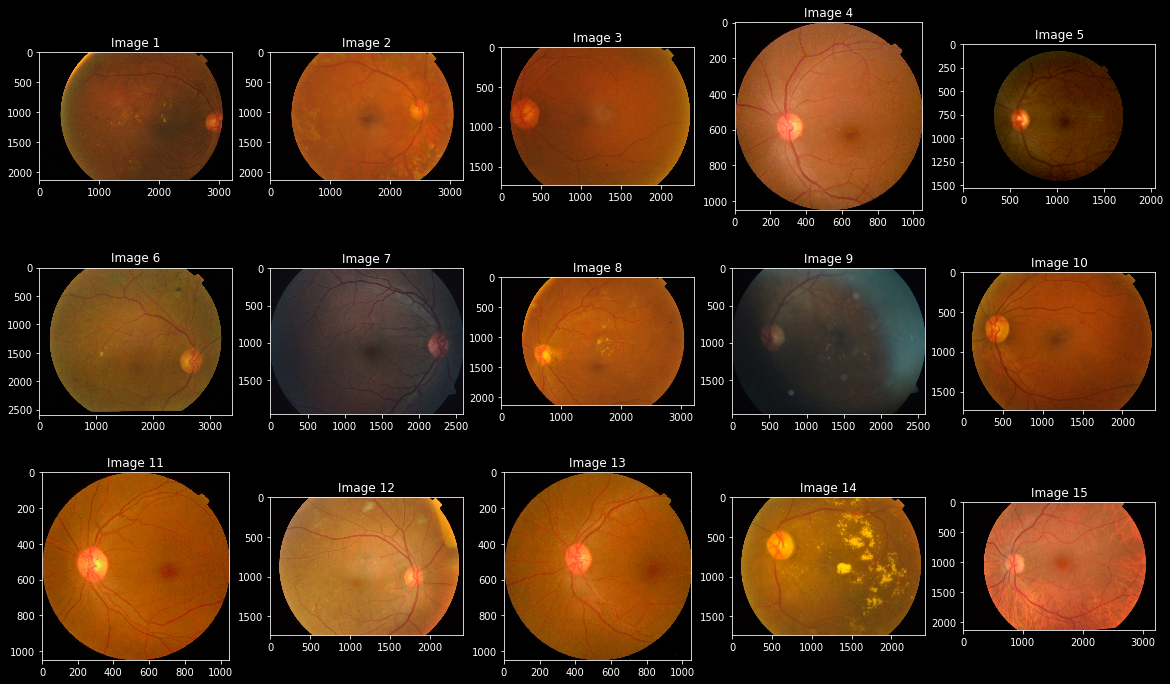

In [26]:
from PIL import Image
plt.figure(figsize=[20, 20])
count = 1
for img_name in df_train['path'][0:15]:
    img = Image.open(img_name)
    plt.subplot(5,5,count)
    plt.imshow(img)
    plt.title('Image %s' % count)
    count += 1


 ### Model Parameters

In [27]:
# Model parameters
BATCH_SIZE = 64
EPOCHS = 20
WARMUP_EPOCHS = 1
LEARNING_RATE = 1e-4
WARMUP_LEARNING_RATE = 1e-3
HEIGHT = 256
WIDTH = 256
CHANNEL = 3
N_CLASSES = df_train['diagnosis'].nunique()

ES_PATIENCE = 5
RLROP_PATIENCE = 3
DECAY_DROP = 0.5


                                                                                



In [28]:
# Preprocess data
df_test['id_file'] = df_test['id_code'].apply(lambda x: x + '.png')
df_test.head()



id_code           id_file
0  0005cfc8afb6  0005cfc8afb6.png
1  003f0afdcd15  003f0afdcd15.png
2  006efc72b638  006efc72b638.png
3  00836aaacf06  00836aaacf06.png
4  009245722fa4  009245722fa4.png

In [29]:
### Data Generator
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255.,
                                   validation_split=0.2,
                                   horizontal_flip=True)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=df_train,
    directory=train_dir,
    x_col='id_file',
    y_col='diagnosis',
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    target_size=(HEIGHT, WIDTH),
    subset='training')

valid_generator = train_datagen.flow_from_dataframe(
    dataframe=df_train,
    directory=train_dir,
    x_col='id_file',
    y_col='diagnosis',
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    target_size=(HEIGHT, WIDTH),
    subset='validation')

test_datagen = ImageDataGenerator(rescale=1./255.)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=df_test,
    directory="./input/test_images/",
    x_col='id_file',
    target_size=(HEIGHT, WIDTH),
    batch_size=1,
    shuffle=False,
    class_mode=None)



Found 2930 validated image filenames belonging to 5 classes.
Found 732 validated image filenames belonging to 5 classes.
Found 1928 validated image filenames.


In [30]:
# from keras import optimizers, applications

# def create_model(input_shape, n_out):
# #    Resnet
# #    input_tensor = Input(shape=input_shape)
# #     base_model = applications.ResNet50(weights=None, 
# #                                        include_top=False,
# #                                        input_tensor=input_tensor)
# #     base_model.load_weights('./input/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5')
#     base_model = applications.VGG16(weights='imagenet',
#                                    include_top=False,
#                                    input_shape=input_shape)
    
#     x = GlobalAveragePooling2D()(base_model.output)
#     x = Dropout(0.5)(x)
#     x = Dense(2048, activation='relu')(x)
#     x = Dropout(0.5)(x)
#     final_output = Dense(n_out, activation='softmax', name='final_output')(x)
#     model = Model(Input(input_shape), final_output)
    
#     return model



In [31]:
# from keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input, Flatten
# from keras.models import Sequential
# from keras import optimizers, applications
from keras.optimizers import Adam
# import tensorflow as tf

# vgg16 = applications.VGG16(weights='imagenet',
#                                    include_top=False,
#                                    input_shape=(HEIGHT, WIDTH, CHANNEL))

# vgg16.summary()



In [32]:
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input, Flatten
from keras.models import Sequential
from keras import optimizers, applications
import tensorflow as tf

# vgg16 = applications.VGG16(weights='imagenet',
#                                    include_top=False,
#                                    input_shape=(HEIGHT, WIDTH, CHANNEL))

# vgg16.summary()

base_model = applications.densenet.DenseNet121(weights='.\input\models\DenseNet-BC-121-32-no-top.h5',
                                               include_top=False,
                                               input_shape=(HEIGHT, WIDTH, CHANNEL))


base_model.summary()

_conv[0][0]        
__________________________________________________________________________________________________
conv5_block4_0_bn (BatchNormali (None, 8, 8, 608)    2432        conv5_block3_concat[0][0]        
__________________________________________________________________________________________________
conv5_block4_0_relu (Activation (None, 8, 8, 608)    0           conv5_block4_0_bn[0][0]          
__________________________________________________________________________________________________
conv5_block4_1_conv (Conv2D)    (None, 8, 8, 128)    77824       conv5_block4_0_relu[0][0]        
__________________________________________________________________________________________________
conv5_block4_1_bn (BatchNormali (None, 8, 8, 128)    512         conv5_block4_1_conv[0][0]        
__________________________________________________________________________________________________
conv5_block4_1_relu (Activation (None, 8, 8, 128)    0           conv5_block4_1_bn[0][0] 

In [33]:
#C:\Users\jaehy\Documents\Kaggle\aptos2019-blindness-detection\input\models\DenseNet-BC-121-32-no-top.h5
!pwd


c:\Users\jaehy\Documents\Kaggle\aptos2019-blindness-detection


In [34]:
# for layer in base_model.layers:
#      layer.trainable = False


# generator new model 
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.5))
model.add(Dense(2048, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(N_CLASSES, activation='softmax'))#, name='final_output'))



In [35]:
# for layer in base_model.layers:
#      layer.trainable = False


# generator new model 
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.5))
model.add(Dense(2048, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(N_CLASSES, activation='softmax'))#, name='final_output'))



In [36]:


metric_list = ['accuracy']
#optimizer = optimizers.Adam(lr=WARMUP_LEARNING_RATE)
model.compile(optimizer=Adam(lr=0.00005), 
              loss="categorical_crossentropy",  
              metrics=['accuracy'])
model.summary()
    



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 8, 8, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1024)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 2048)              2099200   
_________________________________________________________________
dropout_4 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 10245     
Total params: 9,146,949
Trainable params: 9,063,301
Non-trainable params: 83,648
_____________________________________________________________

In [37]:
# STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
# STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size

# history_warmup = model.fit_generator(generator=train_generator,
#                                     steps_per_epoch=STEP_SIZE_TRAIN,
#                                     validation_data=valid_generator,
#                                     validation_steps=STEP_SIZE_VALID,
#                                     epochs=WARMUP_EPOCHS,
#                                     verbose=1).history



In [38]:
# from keras.models import load_model

#model.save(current_name('WORKING','-resnet50.h5'))
# model = load_model("./WORKING/190818a_initialization.h5")



In [39]:
# from numba import cuda
# cuda.select_device(0)
# cuda.close()


 Fine-Tune the complete model

In [40]:
STEP_SIZE_TRAIN = train_generator.n//BATCH_SIZE
STEP_SIZE_VALID = valid_generator.n//BATCH_SIZE

# for layer in model.layers:
#     layer.trainable = True

es = EarlyStopping(monitor='val_loss', mode='min', patience=ES_PATIENCE, 
                   restore_best_weights=True, verbose=1)
rlrop = ReduceLROnPlateau(monitor='val_loss',  mode='min', patience=RLROP_PATIENCE,
                          factor=DECAY_DROP, min_lr=1e-6, verbose=1)
#callback_list = [es, rlrop]
callback_list = [es]
optimizer = optimizers.Adam(lr=LEARNING_RATE)

model.compile(optimizer=optimizer, 
              loss='categorical_crossentropy', 
              metrics=["accuracy"])
model.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 8, 8, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1024)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 2048)              2099200   
_________________________________________________________________
dropout_4 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 10245     
Total params: 9,146,949
Trainable params: 9,063,301
Non-trainable params: 83,648
_____________________________________________________________

In [41]:
history_finetunning = model.fit_generator(generator=train_generator,
                                         steps_per_epoch=STEP_SIZE_TRAIN,
                                         validation_data=valid_generator,
                                         validation_steps=STEP_SIZE_VALID,
                                         epochs=EPOCHS,
                                         callbacks=callback_list,
                                         verbose=1).history



Epoch 1/20


ResourceExhaustedError: OOM when allocating tensor with shape[64,64,64,224] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node training/Adam/gradients/zeros_441-0-1-TransposeNCHWToNHWC-LayoutOptimizer}} = Transpose[T=DT_FLOAT, Tperm=DT_INT32, _device="/job:localhost/replica:0/task:0/device:GPU:0"](training/Adam/gradients/zeros_441, PermConstNCHWToNHWC-LayoutOptimizer)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[{{node metrics_1/acc/Mean/_9043}} = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_39297_metrics_1/acc/Mean", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
